## Алгоритмы машинного обучения. Деревья решений. Случайный лес

In [17]:
# импорт библиотек

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Для сходимости ответов у вас должен быть установлен sklearn версии 0.21.3

In [18]:
#!pip install scikit-learn==0.21.3

In [19]:
print(sklearn.__version__)

0.21.3


In [20]:
# читаем датасет

data = pd.read_csv('titanic_train.csv')

In [23]:
# небольшой препроцессинг

data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data['age'] = np.trunc(data['age'])
data = data.fillna(data.median())

## Поиск порога для разбиения по числовому признаку в деревьях решений.

На практическом занятии мы вручную разбивали исходную выборку по признаку "пол" и смотрели на значение функционала качества при таком разбиении, а также на значения энтропии в двух получившихся после разбиения выборках. Признак "пол" был бинарным, поэтому у нас имелся только один возможный порог для разбиения. В случае с числовыми признаками все иначе.
Если признак числового типа, то в узле формируется правило вида $X_i <= t$. Где $t$ – некоторый порог, который чаще всего выбирается как среднее арифметическое двух соседних упорядоченных значений признака $X_i$ обучающей выборки.
Мы будем работать с признаков "возраст". Найдите с точки зрения функционала качества оптимальный порог для разбиения по этому признаку. Для этого необходимо:
- найти уникальные значения признака "возраст" в исходной выборке, упорядочить их по возрастанию;
- рассчитать средние значения между двумя сосденими элементами получившегося упорядоченного ряда (пример: для ряда [18, 19, 20, 21] результат будет [18.5, 19.5, 20.5]). Они будут являться множеством порогов для поиска;
- среди полученного множества найти тот порог, при котором достигается максимум функции $Q(X, j, t)$, где $X$ – исходная выборка, $j$ – признак ("age"), $t$ - порог, который требуется найти.

Для справки:
$$Q(X, j, t) = H(X) - \dfrac{|X_l|}{|X|} H(X_l) - \dfrac{|X_r|}{|X|} H(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $H(X)$ – энтропия ответов на выборке $X$:
$$H(X) = - \sum_{k=0}^{N}(p_k ln p_k),$$
где $k$ – номер класса, $p_k$ – доля объектов класса $k$ в выборке $X$.

Вы можете использовать функции, которые были реализованы в начале практики.

In [27]:
# Ваш код
def Q(X, j, t):
    Xl = X[X[j] <= t]
    Xr = X[X[j] > t]
    quality = H(X) - len(Xl)/len(X)*H(Xl) - len(Xr)/len(X)*H(Xr)
    return quality

# реализуем функцию для расчета энтропии ответов

def H(X):
    p1 = len(X[X['survived'] == 0]) / len(X)
    p2 = len(X[X['survived'] == 1]) / len(X)
    ent = - (p1*np.log(p1) + p2*np.log(p2))
    return ent

In [28]:
unq_age = data['age'].sort_values().unique()
all_t = [(unq_age[i]+unq_age[i+1])/2 for i in range(0, len(unq_age)-1)]

In [29]:
qlt_crnt = 0
t_opt = 0
for t in all_t:
    qlt = Q(data,'age',t)
    if qlt >= qlt_crnt:
        qlt_crnt = qlt
        t_opt = t
        #print(t_opt)

0.009560320822106338

**<font color='red'>Вопрос 1.</font> Каково оптимальное значение порога разбиеня по признаку "возраст" с точки зрения функционала качества?**
- 7.5
- 8.5
- 9.5
- 10.5

In [37]:
print(t_opt)

9.5


**<font color='red'>Вопрос 2.</font> Каково значение функционала качества Q при разбиении по признаку "возраст" с полученным порогом (округлите до 3-х знаков после запятой)? Является ли такое разбиение более оптимальным по сравнению с разбиением по признаку "пол"?**
- 0.007, да
- 0.010, нет
- 0.010, да
- 0.007, нет

In [38]:
print('Ответ: {}, не является оптимальным'.format(round(Q(data,'age',t_opt),3)))

Ответ: 0.01, не является оптимальным


## Деревья решений

В этом задании мы будем работать с датасетом Сalifornia housing. Решать предстоит задачу регресси: прогнозирование цены недвижимости (признак Price).
Для оценки качества модели мы будем использовать коэффициент детерминации r2. Для подбора гиперпараметров моделей будем использовать обычную пятифолдовую кросс-валидацию.

In [12]:
data = pd.read_csv('California_housing.csv')
X = data.drop('Price', axis = 1)
y = data['Price']

Разделите выборку на обучающую и тестовую в соотношении 7:3. Зафиксируйте `random_state`=20. Так как решаем задачу регрессии, нам не нужно использовать параметр `stratify`.

In [13]:
# Ваш код
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

Обучите дерево решений на обучающей выборке с параметрами по умолчанию (лишь зафиксируйте `random_state`=20) и оцените скор на тестовой. В качестве метрики в этом домашнем задании используйте коэффициент детерминации (функция r2_score из sklearn).

In [14]:
# Ваш код
tree = DecisionTreeRegressor(random_state=20)

In [15]:
tree.fit(X_train, y_train)
preds_test = tree.predict(X_test)
print(r2_score(y_test, preds_test))

0.6376459282414361


Осуществите с помощью GridSearchCV поиск оптимального значения максимальной глубины в дереве. В качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5 (обычная пятифолдовая кросс-валидация). Для поиска оптимального значения максимальной глубины используйте значения от 1 до 20. Выведите получившиеся оптимальное значение гиперпараметра. Сохраните модель с получившимся значением гиперпараметра и оцените скор на тестовой выборке. 

In [16]:
# Ваш код
param_grid = {'max_depth':range(1,21)}
new_tree = DecisionTreeRegressor(random_state=20)
grid = GridSearchCV(estimator=new_tree, param_grid=param_grid, scoring = 'r2', cv = 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=20,
                                             splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 21)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [17]:
print(grid.best_params_)
best_tree = grid.best_estimator_ 
preds_test_new = best_tree.predict(X_test)
print(r2_score(y_test, preds_test_new))

{'max_depth': 9}
0.7071114029124781


**<font color='red'>Вопрос 3.</font> На сколько улучшился скор на тесте после подбора максимальной глубины дерева на кросс-валидации? Ответ округлите до трех знаков после запятой.**

In [18]:
print(round(r2_score(y_test, preds_test_new)-r2_score(y_test, preds_test),3))

0.069


**<font color='red'>Вопрос 4.</font> Визуализируйте построенное дерево с лучшим гиперпараметром (оно может оказаться большим, поэтому используйте ползунки для навигации). Какой признак из оказался самым важным, то есть поместился в вершину построенного дерева решений?**
- MedInc
- HouseAge
- Latitude
- Longitude

In [19]:
from sklearn.tree import export_graphviz

In [20]:
#!pip install graphviz

In [21]:
#conda install python-graphviz

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.563636 to fit


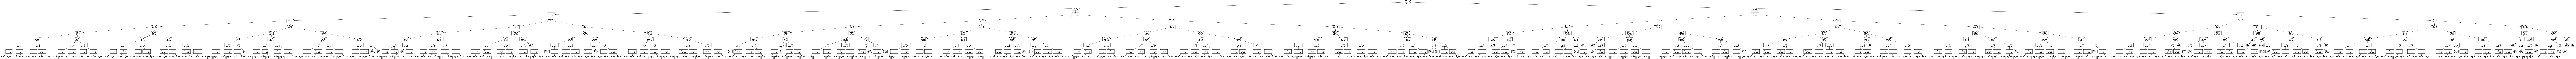

In [22]:
from graphviz import Source
graph = Source(export_graphviz(best_tree, out_file=None, feature_names=X.columns))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

In [23]:
# Ваш код
importances = best_tree.feature_importances_

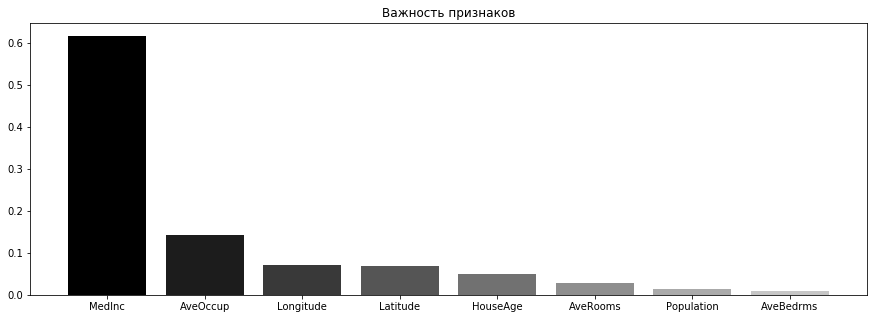

In [24]:
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15,5))
plt.title("Важность признаков")
bars = plt.bar(X_train.columns[indices], 
               importances[indices],
       color=([str(i/float(len(indices)+1)) 
               for i in range(len(indices))]),
               align="center")

Постройте графики зависимости коэффициента детерминации на трейне и кросс-валидации от значения максимальной глубины (кривые валидации). Используйте заданные ранее значения для данного гиперпараметра (остальные гиперпараметры оставьте по умолчанию, зафиксировав лишь `random_state` = 20). В функции cross_val_score так же в качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5.

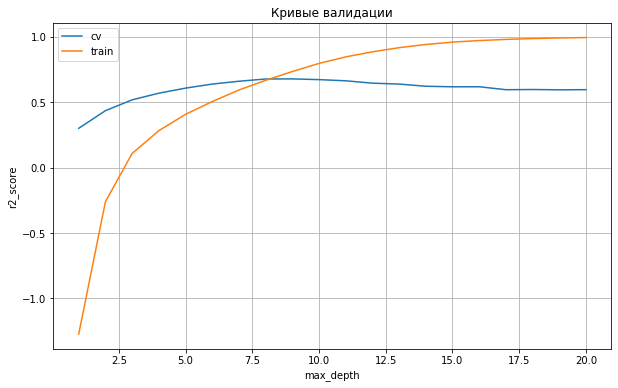

In [25]:
train_scores = []
cv_scores = []
max_depth_values = range(1,21)
for max_depth in max_depth_values:
    model = DecisionTreeRegressor(max_depth = max_depth, random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'r2').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = r2_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, label='cv')
plt.plot(max_depth_values, train_scores, label='train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('r2_score')
plt.legend()
plt.show()

**<font color='red'>Вопрос 5.</font> Какие процессы наблюдаются на кривых валидации при изменени максимальной глубины от 10 до 12 и от 13 до 15 соответственно?**
- недообучение; недообучение
- недообучение; переобучение
- переобучение; недообучение
- переобучение; переобучение

In [39]:
print("Ответ: переобучение; переобучение")

Ответ: переобучение; переобучение


## Случайный лес

Обучите случайный лес на обучающей выборке с параметрами по умолчанию (лишь зафиксируйте `random_state`=20) и оцените скор на тестовой. В качестве меткрики используйте коэффициент детерминации (функция r2_score).

In [27]:
# Ваш код
rf = RandomForestRegressor(random_state=20)
rf.fit(X_train, y_train)
preds_y = rf.predict(X_test)
print(r2_score(y_test, preds_y))

0.7899146118034018


Осуществите с помощью GridSearchCV поиск оптимальных значений максимальной глубины (диапазон для поиска: от 1 до 17 с шагом 2) и минимального числа объектов в листе (диапазон для поиска: от 1 до 21 с шагом 4). В качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5 (обычная пятифолдовая кросс-валидация). Выведите данные оптимальные значения. Сохраните модель с получившимся значениями гиперпараметров и оцените скор на тестовой выборке. 

In [28]:
# Ваш код
param_grid = {'min_samples_leaf': range(1,21,4), 'max_depth':range(1,17,2)}
new_rf = RandomForestRegressor(random_state=20)
grid = GridSearchCV(estimator=new_rf, param_grid=param_grid, scoring='r2', cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=20,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(1, 17, 2),
   

In [29]:
print(grid.best_params_)

{'max_depth': 15, 'min_samples_leaf': 5}


In [30]:
best_rf = grid.best_estimator_
preds_new_y = best_rf.predict(X_test)
print(r2_score(y_test, preds_new_y))

0.7922838987310405


**<font color='red'>Вопрос 6.</font> На сколько улучшился скор на тесте после подбора гиперпараметров случайного леса на кросс-валидации? Ответ округлите до трех знаков после запятой.**

In [31]:
print(round(r2_score(y_test, preds_new_y)-r2_score(y_test, preds_y),3))

0.002


**<font color='red'>Вопрос 7.</font> Оцените важности признаков для случайного леса с лучшим значениями гиперпараметров. Расположите признаки в порядке убывания их важности.**
- MedInc, Latitude, Longitude, HouseAge, AveOccup, AveRooms, Population, AveBedrms
- Longitude, MedInc, Latitude, AveOccup, HouseAge, AveRooms, Population, AveBedrms
- MedInc, AveOccup, Longitude, Latitude, HouseAge, AveRooms, Population, AveBedrms
- Longitude, Latitude, MedInc, AveOccup, HouseAge, AveRooms, Population, AveBedrms

In [40]:
print("Ответ: MedInc, AveOccup, Longitude, Latitude, HouseAge, AveRooms, Population, AveBedrms")

Ответ: MedInc, AveOccup, Longitude, Latitude, HouseAge, AveRooms, Population, AveBedrms


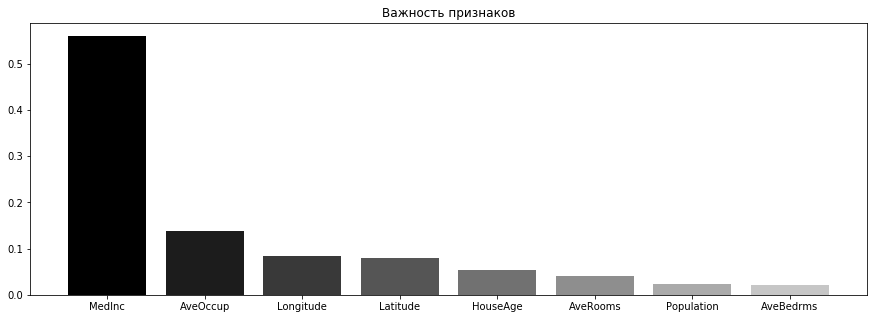

In [39]:
# Ваш код
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15,5))
plt.title("Важность признаков")
bars = plt.bar(X_train.columns[indices], 
               importances[indices],
       color=([str(i/float(len(indices)+1)) 
               for i in range(len(indices))]),
               align="center")

Постройте кривые валидации при подборе максимальной глубины (остальные гиперпараметры оставьте по умолчанию, зафиксировав лишь `random_state` = 20). Используйте заданные ранее значения для данного гиперпараметра. В функции cross_val_score так же в качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5.

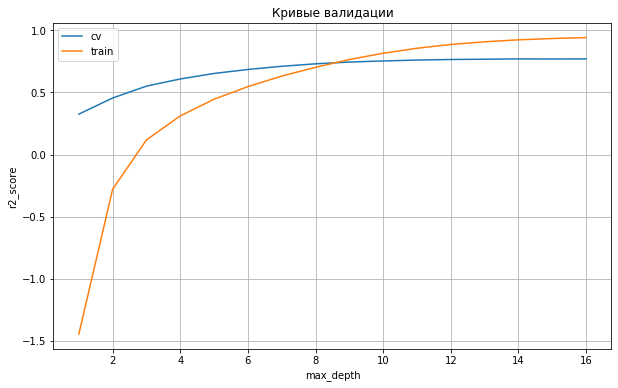

In [34]:
# Ваш код
train_scores = []
cv_scores = []
max_depth_values = range(1,17)
for max_depth in max_depth_values:
    model = RandomForestRegressor(max_depth = max_depth, random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'r2').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = r2_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, label='cv')
plt.plot(max_depth_values, train_scores, label='train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('r2_score')
plt.legend()
plt.show()

**<font color='red'>Вопрос 8.</font> Взгляните на построенные кривые валидации. Что можно добиться в данной задаче, уменьшив максимальную глубину со значения 17? Выберите один, два или ноль правильных ответов.**
- небольшого прироста скора на кросс-валидации
- снижения разности скоров на тренировочной выборке и кросс-валидации при сохранении неплохого скора (> 0.70) на кросс-валидации

In [37]:
print('Ответ: Нет правильных ответов (скор на кросс-валидации <0.7)')

Ответ: Нет правильных ответов (скор на кросс-валидации <0.7)


Постройте кривые валидации при подборе минимального числа объектов в листе (остальные гиперпараметры оставьте по умолчанию, зафиксировав лишь `random_state` = 20). Используйте заданные ранее значения для данного гиперпараметра. В функции cross_val_score так же в качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5.

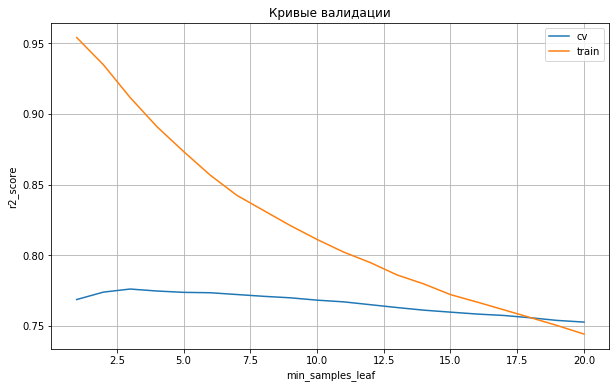

In [35]:
# Ваш код
train_scores = []
cv_scores = []
min_samples_leaf = range(1,21)
for min_leaf in min_samples_leaf:
    model = RandomForestRegressor(min_samples_leaf = min_leaf, random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'r2').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = r2_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf, cv_scores, label='cv')
plt.plot(min_samples_leaf, train_scores, label='train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('min_samples_leaf')
plt.ylabel('r2_score')
plt.legend()
plt.show()

**<font color='red'>Вопрос 9.</font> Взгляните на построенные кривые валидации. Что можно добиться в данной задаче, увеличив минимальное число объектов в листе со значения 1? Выберите один, два или ноль правильных ответов.**
- небольшого прироста скора на кросс-валидации
- снижения разности скоров на тренировочной выборке и кросс-валидации при сохранении неплохого скора (> 0.75) на кросс-валидации

In [36]:
print('Ответ: снижения разности скоров на тренировочной выборке и кросс-валидации при сохранении неплохого скора (> 0.75) на кросс-валидации')

Ответ: снижения разности скоров на тренировочной выборке и кросс-валидации при сохранении неплохого скора (> 0.75) на кросс-валидации
